In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math as m
import scipy.stats as stats
import scipy.special as sc
from scipy.optimize import curve_fit
import pandas as pd
import sys, os
from packs.core import io as io

In [2]:
import pandas as pd
import sys, os

sys.path.append("/home/nulab4/Documents/MULE_WIP/")

from packs.core import io as io

In [3]:
# List of smaller files to process 

files = [r"run19.h5"

]         #replace list with file names eg run1.h5

In [4]:
# MISC VALUES
bin_size         = 4               # ns, time spacing between bins
var              = 200              # waveform number for visualising
negative         = True            # flips from negative to positive

# WINDOW VALUES

WINDOW_START     = 4e2               # ns
WINDOW_END       = 3e4          # ns
BASELINE_POINT_1 = 1e6 # ns, DONT SET THIS TO THE MINIMUM (0)
BASELINE_POINT_2 =  1.5e6          # ns, DONT SET THIS TO THE MAXIMUM
BASELINE_RANGE_1  = 40e3              # ns, DONT LET THIS EXCEED THE MINIMUM/MAXIMUM
BASELINE_RANGE_2  = 40e3           # ns, DONT LET THIS EXCEED THE MINIMUM/MAXIMUM

# PACKAGING THE WINDOW VALUES
window_args = [WINDOW_START, WINDOW_END, BASELINE_POINT_1, BASELINE_POINT_2, BASELINE_RANGE_1, BASELINE_RANGE_2]



In [ ]:
def subtract_baseline(y_data, type = 'median'):
    '''
    determines the value that should be subtracted to produce baseline
    Parameters:
    y_data (array)                   :             waveform data from which baseline is subtracted
    type (string)                    :          Type of badseline to be subtracted (mean, median or mode)
    Returns:
    total (float)                    :           NUmber to be subtracted from all waveforms
    '''


    # convert y_data to numpy array for your own sanity
    y_data = np.array(y_data)

    # MEAN METHOD
    # add all ADC values and divide by length (rough), also remove negatives
    if (type=='mean'):
        total = (np.sum(y_data)/len(y_data))
    # MODE METHOD
    elif (type=='mode'):
        # MODE IS BROKEN
        #value, counts = np.unique(y_data, return_counts=True)
        #m = counts.argmax()
        # counteracting mode being stupid
        #if counts[m] == 1:
         #   print("Only one count of this value, please use a different meth
    elif (type=='median'):
        total = np.median(y_data)
    else:
        print("Please input a baseline method, exiting...")
        return 0
    #print('The baseline value is')
    #print(total)
    # return value to subtractod! (Mode sucks Brais >:( ))")
        #else:
        
        #total = value[m]
        ## SCIPY IS SLOW!
        total = float(stats.mode(y_data)[0])
    # MEDIAN METHOD
    elif (type=='median'):
        total = np.median(y_data)
    else:
        print("Please input a baseline method, exiting...")
        return 0
    #print('The baseline value is')
    #print(total)
    # return value to subtract
    return total


def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or m.fabs(value - array[idx-1]) < m.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def collect_index(time, value):
    '''
    Collects the array index corresponding to a certain time value

    Args:
        time        (np.array)        :     Time array
        value       (float/int)       :     Value that you wish to locate the index of
    '''
    
    val = find_nearest(time, value)
    index = np.where(time == val)[0]

    if len(index == 1):
        return index[0]
    else:
        raise Exception("Must only collect one index! Are you sure you entered the right array?")
        
        
def remove_secondaries(threshold, wf_data, time, event_number, verbose, WINDOW_END):
    '''
    Removes events with large secondary peaks (for example, two alpha events)
    '''
    after_window_wf = wf_data[collect_index(time, WINDOW_END) : len(wf_data)-1]
    time_after = np.linspace(WINDOW_END, 2e6, num=len(after_window_wf), dtype=int) * bin_size # After WINDOW_END
        
    second_peak = np.max(after_window_wf)
    if second_peak > threshold:
        if verbose > 1: 
            plt.plot(time, wf_data)
            plt.xlabel('Time (ns)')
            plt.ylabel('ADCs')
            plt.yscale('log')
            plt.axhline(second_peak, 0, 2e5, c = 'r', ls = '--')
            plt.axvline(WINDOW_END, c = 'r', ls = '--')
            plt.title(f'Event {event_number} subtracted waveform')
            plt.show()
        print(f'Event {event_number} excluded due to large secondary peak')
        return None
    else:
        return wf_data
    
def suppress_baseline(wf_data, threshold):
    '''
    Supresses baseline values, anything below the threshold (including negatives from undershoot) gets set to zero
    '''
    substitute = 0 # This is the zero we set to
    wf_data[wf_data < threshold] = substitute
    return wf_data

### the meaty function

def cook_data(data, bin_size, window_args, chunk_size, chunk_number, negative=False, baseline_mode='median', verbose=1, peak_threshold=800
             ):
    '''
    Collects the charge histograms from waveform arrays via simple processing
    Spits out tuple containing BL-subtracted waveforms and charge of each signal.

    Args:
        data          (np.array)      :       Waveform data
        bin_size      (float)         :       Size of time bins within data
        window_args   (list)          :       List of window values for use in processing
        chunk_size    (int)           :       Size of the 'chunk' of waveform used to ease processing
        chunk_number  (int)           :       Number passed through to track iterations, acts as a label for the chunk
        negative      (bool)          :       Is the waveform negative?
        baseline_mode (string)        :       Mode of the baseline subtraction (median, mode, mean, etc.)
        verbose       (int)           :       Print info: 0 is nothing, 1 is barebones, 2 includes plots
        peak_threshold (float)       :        Threshold for removing peaks

    Returns:
        results(
            sub_data   (array)         :       Baseline subtracted waveforms
        )
    '''
    # Unpack window arguments
    WINDOW_START     = window_args[0]   
    WINDOW_END       = window_args[1]
    BASELINE_POINT_1 = window_args[2]
    BASELINE_POINT_2 = window_args[3]
    BASELINE_RANGE_1 = window_args[4]  
    BASELINE_RANGE_2 = window_args[5]  

    # Define the time array
    time = np.linspace(0, len(data[0]), num=len(data[0]), dtype=int) * bin_size

    sub_data = []
    
    
    for i, wf in enumerate(data):  # Process each waveform
        
        event_number = i + chunk_size * chunk_number
        # Make zero values equal to 1
        threshold = 0
        substitute = 1
        wf[wf <= threshold] = substitute
        # Negative flip
        if negative:
            wf = -wf

        # Plot for debugging (if verbose level is 2)
        if verbose > 1:
            plt.plot(time, wf)
            plt.axvspan(WINDOW_START, WINDOW_END, alpha=0.3, color='red', label='Signal window')
            plt.axvspan(BASELINE_POINT_1 - BASELINE_RANGE_1, BASELINE_POINT_1 + BASELINE_RANGE_1, alpha=0.3, color='blue', label='Baseline bands')
            plt.axvspan(BASELINE_POINT_2 - BASELINE_RANGE_2, BASELINE_POINT_2 + BASELINE_RANGE_2, alpha=0.3, color='blue')
            plt.xlabel('Time (us)')
            plt.ylabel('ADCs')
            plt.title(f'Event {i} waveform')
            plt.legend()
            plt.show()

        # ### Baseline subtraction ###
        # Collect the baseline region data (sidebands)
        bl_range_1 = [collect_index(time, BASELINE_POINT_1 - BASELINE_RANGE_1), collect_index(time, BASELINE_POINT_1 + BASELINE_RANGE_1)]
        bl_range_2 = [collect_index(time, BASELINE_POINT_2 - BASELINE_RANGE_2), collect_index(time, BASELINE_POINT_2 + BASELINE_RANGE_2)]
        y_sideband = wf[bl_range_1[0]:bl_range_1[1]]
        y_sideband = list(y_sideband) + list(wf[bl_range_2[0]:bl_range_2[1]])

        # Subtract the baseline value from the waveform
        sub_wf = wf - subtract_baseline(y_sideband, type=baseline_mode)
        
        # Suppress baseline
        sup_wf = suppress_baseline(sub_wf, 10)
        
        # Remove secondary alphas
        final_wf = remove_secondaries(peak_threshold, sup_wf, time, event_number, verbose, WINDOW_END)
        if final_wf is None:
            continue
            
        sub_data.append(final_wf)
        
        if verbose > 1:
            # Plot subtracted waveform for debugging
            plt.plot(time, sub_wf)
            plt.xlabel('Time (us)')
            plt.ylabel('ADCs')
            plt.title(f'Event {i} subtracted waveform')
            plt.show()

    # Return subtracted waveforms
    return sub_data


In [21]:
# Variables to accumulate sum and count
waveform_sum = None
num_waveforms = 0

# Define a chunk size to process data in manageable parts
chunk_size = 5
chunk_number = 0


# Loop through each file and process the waveforms in chunks
for filepath in files:
    if os.path.exists(filepath):
        print(f"Processing file: {filepath}")

        x = io.load_rwf_info(filepath, samples=2)
        waveforms = x.rwf.values

        # Get the total number of waveforms in the current file
        total_waveforms = waveforms.shape[0]

        # Process the data in chunks to avoid memory overload, cooks data in chunks also
        for start_idx in range(0, total_waveforms, chunk_size):
            end_idx = min(start_idx + chunk_size, total_waveforms)
            waveform_chunk = waveforms[start_idx:end_idx]

            # Process the chunk, passing the event_number
            sub_wf_chunk = cook_data(
                waveform_chunk, bin_size, window_args, chunk_size, chunk_number, negative=negative, 
                baseline_mode='mode', verbose=1, peak_threshold= 1000
            )
            
            # Make the sum array with the shape of the first chunk of waveforms
            if waveform_sum is None:
                waveform_sum = np.zeros_like(sub_wf_chunk[0], dtype=np.float64)
            
            # Add the chunk of waveforms to the running sum
            if len(sub_wf_chunk) == 0:
                continue  # Skip this iteration
            waveform_sum += np.sum(sub_wf_chunk, axis=0)
            
            # Update the number of waveforms processed
            num_waveforms += len(sub_wf_chunk)
            
            chunk_number +=1
                
    else:
        print(f"File not found: {filepath}")

# Average the waveforms (not sum anymore)
average_waveform = waveform_sum / num_waveforms
del x

Processing file: run19.h5


/home/nulab4/Documents/MULE_WIP/packs/core/io.py:45: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(file_path) as f:


Event 23 excluded due to large secondary peak
Event 68 excluded due to large secondary peak
Event 77 excluded due to large secondary peak
Event 129 excluded due to large secondary peak
Event 151 excluded due to large secondary peak
Event 175 excluded due to large secondary peak
Event 221 excluded due to large secondary peak
Event 227 excluded due to large secondary peak
Event 233 excluded due to large secondary peak
Event 235 excluded due to large secondary peak
Event 236 excluded due to large secondary peak
Event 243 excluded due to large secondary peak
Event 244 excluded due to large secondary peak
Event 254 excluded due to large secondary peak
Event 283 excluded due to large secondary peak
Event 308 excluded due to large secondary peak
Event 334 excluded due to large secondary peak
Event 370 excluded due to large secondary peak
Event 397 excluded due to large secondary peak
Event 403 excluded due to large secondary peak
Event 408 excluded due to large secondary peak
Event 409 exclud

Event 2889 excluded due to large secondary peak
Event 2894 excluded due to large secondary peak
Event 2911 excluded due to large secondary peak
Event 2912 excluded due to large secondary peak
Event 2930 excluded due to large secondary peak
Event 2941 excluded due to large secondary peak
Event 2951 excluded due to large secondary peak
Event 2987 excluded due to large secondary peak
Event 3005 excluded due to large secondary peak
Event 3023 excluded due to large secondary peak
Event 3097 excluded due to large secondary peak
Event 3106 excluded due to large secondary peak
Event 3120 excluded due to large secondary peak
Event 3147 excluded due to large secondary peak
Event 3154 excluded due to large secondary peak
Event 3160 excluded due to large secondary peak
Event 3197 excluded due to large secondary peak
Event 3227 excluded due to large secondary peak
Event 3228 excluded due to large secondary peak
Event 3229 excluded due to large secondary peak
Event 3236 excluded due to large seconda

In [26]:
def average_waveforms(files, bin_size, window_args, chunk_size = 5, negative=False, baseline_mode='median', verbose=1, peak_threshold=800):
    # Variables to accumulate sum and count
    waveform_sum = None
    num_waveforms = 0
    chunk_number = 0
    # Loop through each file and process the waveforms in chunks
    for filepath in files:
        if os.path.exists(filepath):
            print(f"Processing file: {filepath}")

            x = io.load_rwf_info(filepath, samples=2)
            waveforms = x.rwf.values

            # Get the total number of waveforms in the current file
            total_waveforms = waveforms.shape[0]

            # Process the data in chunks to avoid memory overload, cooks data in chunks also
            for start_idx in range(0, total_waveforms, chunk_size):
                end_idx = min(start_idx + chunk_size, total_waveforms)
                waveform_chunk = waveforms[start_idx:end_idx]

                # Process the chunk, passing the event_number
                sub_wf_chunk = cook_data(
                    waveform_chunk, bin_size, window_args, chunk_size, chunk_number, negative, 
                    baseline_mode, verbose, peak_threshold
                )
            
                # Make the sum array with the shape of the first chunk of waveforms
                if waveform_sum is None:
                    waveform_sum = np.zeros_like(sub_wf_chunk[0], dtype=np.float64)
            
                # Add the chunk of waveforms to the running sum
                if len(sub_wf_chunk) == 0:
                    continue  # Skip this iteration
                waveform_sum += np.sum(sub_wf_chunk, axis=0)
            
                # Update the number of waveforms processed
                num_waveforms += len(sub_wf_chunk)
            
                chunk_number +=1
                
        else:
            print(f"File not found: {filepath}")

    # Average the waveforms (not sum anymore)
    average_waveform = waveform_sum / num_waveforms
    del x
    return average_waveform

In [42]:
avgwf = average_waveforms(files, bin_size, window_args, chunk_size = 5, negative=negative, baseline_mode='median', verbose=1, peak_threshold=1000)


Processing file: run19.h5


/home/nulab4/Documents/MULE_WIP/packs/core/io.py:45: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(file_path) as f:


Event 23 excluded due to large secondary peak
Event 68 excluded due to large secondary peak
Event 77 excluded due to large secondary peak
Event 129 excluded due to large secondary peak
Event 151 excluded due to large secondary peak
Event 175 excluded due to large secondary peak
Event 221 excluded due to large secondary peak
Event 227 excluded due to large secondary peak
Event 233 excluded due to large secondary peak
Event 235 excluded due to large secondary peak
Event 236 excluded due to large secondary peak
Event 243 excluded due to large secondary peak
Event 244 excluded due to large secondary peak
Event 254 excluded due to large secondary peak
Event 283 excluded due to large secondary peak
Event 308 excluded due to large secondary peak
Event 334 excluded due to large secondary peak
Event 370 excluded due to large secondary peak
Event 397 excluded due to large secondary peak
Event 403 excluded due to large secondary peak
Event 408 excluded due to large secondary peak
Event 409 exclud

Event 2894 excluded due to large secondary peak
Event 2911 excluded due to large secondary peak
Event 2912 excluded due to large secondary peak
Event 2930 excluded due to large secondary peak
Event 2941 excluded due to large secondary peak
Event 2951 excluded due to large secondary peak
Event 2987 excluded due to large secondary peak
Event 3005 excluded due to large secondary peak
Event 3023 excluded due to large secondary peak
Event 3097 excluded due to large secondary peak
Event 3106 excluded due to large secondary peak
Event 3120 excluded due to large secondary peak
Event 3147 excluded due to large secondary peak
Event 3154 excluded due to large secondary peak
Event 3160 excluded due to large secondary peak
Event 3197 excluded due to large secondary peak
Event 3227 excluded due to large secondary peak
Event 3228 excluded due to large secondary peak
Event 3229 excluded due to large secondary peak
Event 3236 excluded due to large secondary peak
Event 3244 excluded due to large seconda

In [43]:
np.savetxt('Avg_wftest.csv', avgwf, delimiter = ',')

In [44]:
average_waveform_1 = np.genfromtxt('Avg_wftest.csv', delimiter = ',')
average_waveform_2 = np.genfromtxt('Avg_wftest2.csv', delimiter = ',')


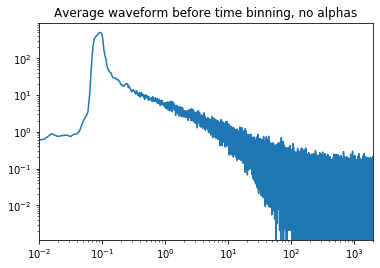

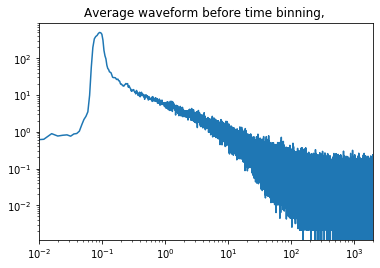

In [45]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000


time_linear_1 = np.linspace(0, 2e3, len(average_waveform_1))
plt.plot(time_linear_1 - 19.6, average_waveform_1)
plt.yscale('log')
plt.xscale('log')
plt.title('Average waveform before time binning, no alphas')
plt.xlim(1e-2, 2e3)
#plt.ylim(-6, 20)
plt.show()
time_linear_2 = np.linspace(0, 2e3, len(average_waveform_2))
plt.plot(time_linear_2 - 19.6, average_waveform_2)
plt.yscale('log')
plt.xscale('log')
plt.title('Average waveform before time binning, ')
plt.xlim(1e-2, 2e3)
#plt.ylim(-6, 20)
plt.show()

In [46]:
def binning(average_waveform, time_linear, t_max, log = True, peak_position = 4e-5, num_bins = 100):
        '''
    Bins an average wavefom

    Args:
        average_waveform (np.array)      :       Waveform data
        time_linear (float)         :       Linspace defining the time for the wavefomr
        t_max (float)          :       The end time of the waveform
        log  (bool)          :       Do we want logarithmic binning?
        peak_position (float)   :       The desired position of the initial peak
        '''
        # Removing low time values (below 1 microsecond)
        time_threshold = 1e-10  # 1 corresponds to 1 µs
        mask = time_linear >= time_threshold  # Keep only times greater than zero (for log purposes)

        np.set_printoptions(threshold=1000)
        # Apply the mask to filter both time_data and y_data (waveform)
        
        
        filtered_time = time_linear[mask]
        filtered_waveform = average_waveform[mask]
        assert len(filtered_time) == len(filtered_waveform)
        
        t_min = 1e-10 # Starting point of time

        # Align the peak to the desired position
        peak_index = np.argmax(filtered_waveform) 
        current_peak_time = filtered_time[peak_index]
        shift = peak_position - current_peak_time
        shifted_time = filtered_time + shift
        
        binned_waveform = []
        binned_time = []
        bin_size = []
        bin_unc = []
    
        if log:   # Is our binning logarithmic?
            log_bins = np.logspace(np.log10(t_min), np.log10(t_max), num=num_bins)
            bin_indices = np.digitize(shifted_time, log_bins)
                # Average waveform amount in each bin
            for i in range(1, len(log_bins)):
                bin_mask = (bin_indices == i)
                binned_y = filtered_waveform[bin_mask]
                binned_t = shifted_time[bin_mask]
                if len(binned_y) > 0:
                    # Bin width
                    bin_width = log_bins[i] - log_bins[i-1]
                    binned_waveform.append(np.mean(binned_y))  # Mean of waveform values in the bin
                    # Midpoint of the bin (for plotting)
                    midpoint = np.sqrt(log_bins[i-1] * log_bins[i])
                    binned_time.append(midpoint)  # Use midpoint for binned time
                    bin_size.append(bin_width)
                    # Uncertainty
                    num_counts = len(binned_y) # Number of events in the bin
                    std = np.std(binned_y, ddof = 1)
                    err_mean = std / np.sqrt(num_counts)
                    err_counts = np.sum(binned_y) / num_counts**2
                    unc = np.sqrt(err_mean**2 + err_counts**2) 
                    bin_unc.append(unc)
                else:
                    # If there is no data in the bin, skip adding to the lists
                    continue
        else:
            # This is for linear binning, there is no error propogation for this yet
            log_bins = np.linspace(t_min, t_max, num=num_bins)
            bin_indices = np.digitize(shifted_time, log_bins)
            for i in range(1, len(log_bins)):
                bin_mask = (bin_indices == i)
                binned_y = filtered_waveform[bin_mask]
                binned_t = shifted_time[bin_mask]
                if len(binned_y) > 0:
                    bin_width = log_bins[i] - log_bins[i-1]
                    binned_waveform.append(np.sum(binned_y))  # Sum of waveform values in the bin
                    midpoint = np.sqrt(log_bins[i-1] * log_bins[i])
                    binned_time.append(midpoint)
                    bin_size.append(bin_width)
                    bin_unc.append(np.sqrt(len(binned_y)))
                else:
                    continue

        # Make Numpy arrays
        binned_waveform = np.array((binned_waveform))
        binned_time = np.array(binned_time)
        bin_size = np.array(bin_size)
        bin_unc = np.array(bin_unc)
        # Remove NaN values to fix length mismatch
        NaN_mask = ~np.isnan(binned_waveform)
        binned_waveform = binned_waveform[NaN_mask]
        bin_size = bin_size[NaN_mask]
        bin_unc =bin_unc[NaN_mask]
        total_area = np.sum(binned_waveform * bin_size)  # Integral approximation
        normalised_waveform = binned_waveform / total_area  # Normalize to make the integral = 1
        normalised_unc = bin_unc / total_area
    
        return normalised_waveform , binned_time, normalised_unc

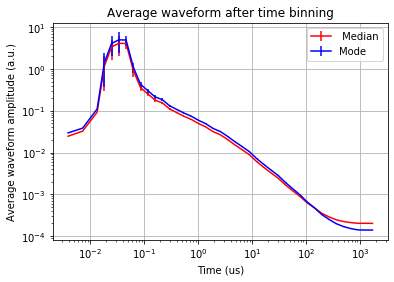

In [48]:
AW_2 = binning(average_waveform_2, time_linear_2, 2e3, log = True, peak_position=4e-2, num_bins = 100)
plt.errorbar(AW_2[1], AW_2[0], AW_2[2],fmt = 'r', label = ' Median')

AW_1 = binning(average_waveform_1, time_linear_1, 2e3, log = True, peak_position=4e-2, num_bins = 100)
plt.errorbar(AW_1[1], AW_1[0], AW_1[2], fmt = 'b', label = 'Mode')

plt.yscale('log')
plt.legend()
plt.xscale('log')
plt.xlabel('Time (us)')
plt.grid()
plt.ylabel('Average waveform amplitude (a.u.)')
plt.title('Average waveform after time binning')
#plt.xlim(1e-5,2e3)
plt.show()

In [38]:
# V&L Model
def I_prompt(N_p, T_s, t):
    return (N_p / T_s) * np.exp(-(t) / T_s)

def E_i(x):
    Integral = sc.expi(x)
    return Integral

def F(t, T_t, A, t_a):
    return  np.exp(-2*t / T_t) / ((1 + A*(E_i( (-t+t_a) / T_t) - E_i((-t_a) / T_t)))**2 * (1 + t / t_a))
                                  
def I_delayed(N_d, t, T_t, A, t_a):
    T_d = np.sum(F(t, T_t, A, t_a)) # T_d is an integral of F for normalisation
    return  (N_d / T_d) * F(t, T_t, A, t_a)

def V_L(t, N_p, T_s, N_d, A, t_a, T_t, c, x):
    t1 = t - x
    return I_prompt(N_p, T_s, t1) + I_delayed(N_d, t1, T_t, A, t_a) + c

In [39]:
# Finding the window for fitting
AW_1 = binning(average_waveform_1, time_linear_1, 2e3, log = True, peak_position=4e-2, num_bins = 100)

binned_data = AW_1
peak_index = np.nanargmax(binned_data[0])
x = 0 # Peak index shift
binned_time_window =  binned_data[1][peak_index+x:]
binned_waveform_window = binned_data[0][peak_index+x:]
binned_sigma_window = binned_data[2][peak_index+x:]

In [40]:
# Parameters for V&L
# N_p, T_s, N_d, A, t_a, T_t, c, x
# c is a constant for baseline, x is time shift of the peak
#V_L_params = (0.21, 5.6e-3, 0.79, 0, 0.08, 2e2, 2e-4, 4e-2)
V_L_params = (0.0001076553763082888, 0.007611319146153545, 2.591418445893896, -0.07292125634508369, 0.10259477698921043, 188.19686751938912, 2e-4, 4e-2)

# Curve fit
popt, pcov = curve_fit(V_L, binned_time_window, binned_waveform_window, p0 = V_L_params, sigma = binned_sigma_window)
p_sigma = np.sqrt(np.diag(pcov)) # Errors on parameters

/home/nulab4/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Np = -0.048523 ± 0.010947
Ts = 0.996377 ± 0.167482
N_d = 2.141501 ± 0.271401
A = 0.041135 ± 0.013614
ta = 0.329768 ± 0.083878
Tt = 511.112279 ± 25.253410


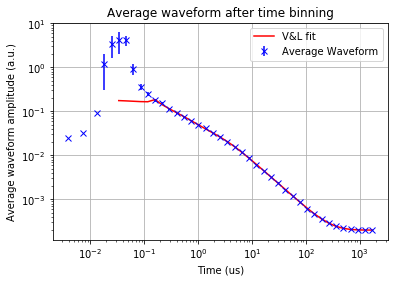

In [41]:
# Our time is from AW[1] with the window for fitting
time_AW = binned_time_window

# With Chris' parameters
V_L_data = V_L(binned_data[1], V_L_params[0], V_L_params[1], V_L_params[2], V_L_params[3], V_L_params[4], V_L_params[5], V_L_params[6], V_L_params[7])

# WIth curve fit params
V_L_fit = V_L(time_AW, popt[0],popt[1],popt[2],popt[3],popt[4],popt[5], popt[6], popt[7])

plt.plot(time_AW, V_L_fit, 'r', label = 'V&L fit')
plt.xscale('log')
plt.yscale('log')

print(f'Np = {popt[0]:2f} \u00B1 {p_sigma[0]:2f}\nTs = {popt[1]:2f} \u00B1 {p_sigma[1]:2f}\nN_d = {popt[2]:2f} \u00B1 {p_sigma[2]:2f}\nA = {popt[3]:2f} \u00B1 {p_sigma[3]:2f}\nta = {popt[4]:2f} \u00B1 {p_sigma[4]:2f}\nTt = {popt[5]:2f} \u00B1 {p_sigma[5]:2f}')

plt.errorbar(AW_1[1], AW_1[0], yerr=AW_1[2], fmt='bx',label = 'Average Waveform')
#print(f"The uncertainties are: {AW_1[2]}")

plt.yscale('log')
plt.legend()
plt.xscale('log')
plt.xlabel('Time (us)')
plt.grid()
plt.ylabel('Average waveform amplitude (a.u.)')
plt.title('Average waveform after time binning')
plt.show()